# Proyecto aplicado: "Pokemon_data"
* Andrés Forero
* Daniel Cuellar
* Daniela González 




## Librerías 
______

In [150]:
from builtins import len

# manejo de data
import pandas as pd
import numpy as np
import math
from scipy import stats
# visualización
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

import plotly.express as px

from sklearn.metrics import classification_report

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [151]:
sns.set_context("paper")
sns.set_style("whitegrid")

# Metodología CRISP-DM
___
<img src="http://www.iic.uam.es/wp-content/uploads/2021/11/CRISP-DM.jpg" width="400" height="400" />


## Situación actual


Pokémon por mas de 25 años ha logrado conquistar los corazones de diferentes generaciones gracias a su animación, videojuegos y tarjetas coleccionables, siendo hoy en día mundialmente popular.
En el mundo Pokémon, existen diferentes tipos que clasifican a las criaturas según sus características y habilidades. Cada tipo tiene sus fortalezas y debilidades, lo que añade una capa estratégica al juego; entre los que se encuentran:
Tipo fuego, agua, planta, eléctrico, volador, tierra, roca, lucha, psíquico, veneno, hielo, acero, fantasma, dragón, hada, entre otros.
Cada tipo tiene sus propias habilidades de ataque y defensa, por lo que la estrategia al construir un equipo de Pokémon es clave para tener éxito en batallas y desafíos.

## Descripción del dataset
_______________


El dataset “The Complete Pokemon Dataset” se obtuvo de Kaggle. El conjunto de datos contiene información sobre los 802 Pokémon de las Siete Generaciones de Pokémon. La información incluye estadísticas base, rendimiento frente a otros tipos, altura, peso, clasificación, pasos de huevo, puntos de experiencia, habilidades, etc.

## Problema
_____


## Objetivos
_____

### General

 Implementar modelos de aprendizaje supervisado y no supervisado, aplicando transformaciones adecuadas a las características de entrada, con el fin de lograr una presición mayor en la clasificación y el agrupamiento.


### Específico 

Realizar un análisis comparativo de los modelos de aprendizaje supervisado para clasificar si un pokémon es legendario, evaluando su presición y score. Además de aplicar el análisis de componentes principales (PCA) para determinar el número de componentes óptimo, que explique de manera efectiva los datos.

Aplicar el modelo no supervisado K-means para agrupar los pokémon con mayor similitud en sus habilidades (ataque, defensa, velocidad, entre otros).

Desarrollar un modelo supervisado para la tipificación de los pokémon 

## Hipótesis (científica o estadística)
------


# Entendimiento de los datos
----

## Carga De Datos


In [152]:
data = pd.read_csv("pokemon.csv")

## Describir los datos 


Este conjunto de datos contiene información sobre los 802 Pokémon de las Siete Generaciones de Pokémon, y el cual contiene las siguientes características.


* Name: El nombre en inglés del Pokémon.
* Japanese_name: El nombre japonés original del Pokémon
* Pokedex_number: El número de entrada del Pokémon en el Pokédex Nacional
* Percent_male: El porcentaje de las especies que son machos. En blanco si el Pokémon no tiene género.
* Type1: El tipo primario del Pokémon
* Type2: El tipo secundario del Pokémon
* Clasificación: La clasificación de los Pokémon como se describe en el Sol y la Luna Pokédex
* Height_m: Altura del Pokémon en metros
* Weight_kg: El Peso del Pokémon en kilogramos
* Capture_rate: Tasa de captura del Pokémon
* Base_egg_steps: La cantidad de pasos necesarios para eclosionar un huevo del Pokémon
* Abilities:Lista ordenada de habilidades que el Pokémon es capaz de tener.
* Experience_growth: Cantidad de puntos que obtiene un Pokémon al derrotar a otro en un combate y subir de nivel
* Base_happiness: Felicidad Base del Pokémon
* Against_?: Dieciocho características que denotan la cantidad de daño recibido contra un ataque de un tipo particular
* Base_total:Suma de las características del pokémon "attack", "defense", "hp", "sp_attack", "sp_defense" y "speed"
* HP: (Health Points) condición fisica del Pokémon, representada con un valor numérico
* Attack:El Ataque Base de los Pokémon
* Defense:La Defensa Base de los Pokémon
* Sp_attack: El Ataque Especial Base del Pokémon
* Sp_defense: La Defensa Especial Base del Pokémon
* Speed:La velocidad base del Pokémon
* Generation: Generación numerada en la que se introdujo por primera vez el Pokémon
* Is_legendary:Indica si el Pokémon es legendario.

In [153]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [154]:
data.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


## Limpieza de datos

Se valida que la variable "base_total" esta compuesta por la suma de las características "attack", "defense", "hp", "sp_attack", "sp_defense" y "speed"

In [155]:
prueba_base=data['attack']+data['defense']+data['hp']+data['sp_attack']+data['sp_defense']+data['speed']
comparacion=prueba_base==data['base_total']
comparacion.sum()

801

### Valores nulos

In [156]:
nulos = data.isnull().sum(axis=0)
nulos[nulos>0]

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

Dado que hay solo 20 faltantes para height_m y weight_kg, se decide buscar la información faltante en una base externa [Pokédex](https://www.pokemon.com/el/pokedex).

In [157]:
data_missing= pd.read_csv("pokemons_faltantes.csv", sep=";")

data_missing.rename(columns={"weight_km":"weight_kg"})

,name,height_m,weight_kg
0,Rattata,0.3,3.5
1,Raticate,0.7,18.5
2,Raichu,0.8,30.0
3,Sandshrew,0.6,12.0
4,Sandslash,1.0,29.5
5,Vulpix,0.6,9.9
6,Ninetales,1.1,19.9
7,Diglett,0.2,0.8
8,Dugtrio,0.7,33.3
9,Meowth,0.2,0.8


In [158]:
data_missing= pd.read_csv("pokemons_faltantes.csv", sep=";")
data_missing.rename(columns={"weight_km":"weight_kg"})
df2=pd.merge(data_missing, data, on="name")
df2=df2.drop(["height_m_y", "weight_kg_y"], axis=1)
df2=df2.rename(columns={"weight_kg_x":"weight_kg", "height_m_x": "height_m"})
data_fix=data[data["weight_kg"].notna() ]
data_fix
a=data_fix.columns.tolist()
df2=df2[a]
data = pd.concat([data_fix,df2], axis=0)

In [159]:
nulos = data.isnull().sum(axis=0)
nulos[nulos>0]

percentage_male     98
type2              384
dtype: int64

### Sexo del pokémon

Se crea una columna adicional para el porcentaje de sexo femenino, por ende, para los pokemón que no poseen sexo, se dejan en 0 las 2 columnas de sexo.

In [160]:
data["percentage_female"]= [ 0 if pd.isna(i) else 100-i for i in data.percentage_male]
data["percentage_male"]=data["percentage_male"].fillna(0)

### Ajuste de tasa de captura

In [161]:
data.capture_rate.unique()

array(['45', '255', '120', '90', '190', '235', '150', '25', '170', '50',
       '75', '200', '100', '180', '60', '225', '30', '35', '3', '65',
       '70', '127', '125', '205', '155', '145', '130', '140', '15', '220',
       '160', '80', '55', '30 (Meteorite)255 (Core)'], dtype=object)

In [162]:
data.loc[data.capture_rate=='30 (Meteorite)255 (Core)',"capture_rate"]=30

data['capture_rate'] = data['capture_rate'].astype(int)

### Descarte de variables

Se descartan las siguientes variables:
* abilitites: están fuera del alcance.
* classfication: no provee mucha información.
* japanese_name: se va a trabajar con el nombre en inglés "name".
* pokedex_number: al ser un índice no da información adicional.
* type2: la mayoría de registros son de 1 solo tipo por ende se deja fuera del alcance.

In [163]:
datos = data.loc[:,~data.columns.isin(["abilities","classfication","japanese_name","pokedex_number","type2"])]

## Estadística exploratoria
------

In [164]:
categorical_data = data.select_dtypes(include=['object']).columns
def est_exploratoria(data,categoricas):
    """
    tablas de estadística exploratoria
    ---
    data : dataframe
    categoricas : lista con nombre de variables a tratar como categoricas
    
    """
    datos = data.loc[:,~data.columns.isin(categoricas)]

    df0 = datos.agg([lambda x : sum(x.isna()),"count",]).rename(index={"<lambda>": 'Na count'})
    df1 = datos.agg(["mean"])
    df2 = datos.agg(pd.Series.mode).loc[[0]].rename(index={0: 'mode'})
    df3 = datos.agg(["median","std","var","kurt","skew","max","min"])

    df = pd.concat([df0,df1,df2, df3])

    df["Measurement"] = df.index
    df["Type"]=["Structure","Structure","Central t.","Central t.","Central t.","Dispersion","Dispersion","Shape","Shape","Range","Range"]
    df.set_index("Type", append=False, inplace=True)
    df.set_index("Measurement", append=True, inplace=True)

    numerica=df.round(decimals=2)

    datos = data.loc[:,data.columns.isin(categoricas)]


    df0 = datos.agg([lambda x : sum(x.isna())]).rename(index={"<lambda>": 'Na count'})

    df = pd.concat([df0,datos.describe(include=['object',"string"])])

    categorica=df.round(decimals=2)
    return numerica, categorica

numerica, categorica = est_exploratoria(datos,categorical_data)

numerica


against_bug  against_dark  against_dragon   
Type       Measurement                                              
Structure  Na count            0.00          0.00            0.00  \
           count             801.00        801.00          801.00   
Central t. mean                1.00          1.06            0.97   
           mode                1.00          1.00            1.00   
           median              1.00          1.00            1.00   
Dispersion std                 0.60          0.44            0.35   
           var                 0.36          0.19            0.12   
Shape      kurt                5.00          5.41            4.45   
           skew                1.76          1.72            0.00   
Range      max                 4.00          4.00            2.00   
           min                 0.25          0.25            0.00   

                        against_electric  against_fairy  against_fight   
Type       Measurement                                                   
Structure  Na count                 0.00           0.00           0.00  \
           count                  801.00         801.00         801.00   
Central t. mean                     1.07           1.07           1.07   
           mode                     1.00           1.00           1.00   
           median                   1.00           1.00           1.00   
Dispersion std                      0.65           0.52           0.72   
           var                      0.43           0.27           0.51   
Shape      kurt                     2.11           9.83           2.68   
           skew                     0.93           2.48           1.26   
Range      max                      4.00           4.00           4.00   
           min                      0.00           0.25           0.00   

                        against_fire  against_flying  against_ghost   
Type       Measurement                                                
Structure  Na count             0.00            0.00           0.00  \
           count              801.00          801.00         801.00   
Central t. mean                 1.14            1.19           0.99   
           mode                 1.00            1.00           1.00   
           median               1.00            1.00           1.00   
Dispersion std                  0.69            0.60           0.56   
           var                  0.48            0.37           0.31   
Shape      kurt                 3.75            5.06           2.03   
           skew                 1.61            1.77           0.45   
Range      max                  4.00            4.00           4.00   
           min                  0.25            0.25           0.00   

                        against_grass  ...  height_m      hp  percentage_male   
Type       Measurement                 ...                                      
Structure  Na count              0.00  ...      0.00    0.00             0.00  \
           count               801.00  ...    801.00  801.00           801.00   
Central t. mean                  1.03  ...      1.16   68.96            48.41   
           mode                  1.00  ...      0.60   60.00            50.00   
           median                1.00  ...      1.00   65.00            50.00   
Dispersion std                   0.79  ...      1.07   26.58            26.22   
           var                   0.62  ...      1.15  706.28           687.31   
Shape      kurt                  4.59  ...     43.85    8.33            -0.03   
           skew                  1.97  ...      5.12    1.83            -0.33   
Range      max                   4.00  ...     14.50  255.00           100.00   
           min                   0.25  ...      0.10    1.00             0.00   

                        sp_attack  sp_defense   speed  weight_kg  generation   
Type       Measurement                                                         
Structure  Na count      

In [165]:
categorica

,name,type1
Na count,0,0
count,801,801
unique,801,18
top,Bulbasaur,water
freq,1,114


## Visualización de datos
------

In [166]:
contras=datos[datos.columns[
    (pd.Series(datos.columns).str.startswith('against')) | 
    (datos.columns=="type1")]].groupby(["type1"]).agg("mean")

contras.head()


,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water
type1,,,,,,,,,,,,,,,,,,
bug,0.826389,0.979167,0.937500,1.138889,0.916667,0.458333,2.194444,2.083333,1.013889,0.420139,0.562500,1.208333,0.930556,0.930556,1.159722,2.291667,0.972222,1.020833
dark,1.724138,0.534483,1.103448,1.103448,2.275862,1.965517,1.034483,1.034483,0.551724,0.775862,0.965517,1.206897,0.931034,0.913793,0.000000,1.241379,1.000000,1.000000
dragon,0.944444,1.037037,2.000000,0.490741,2.111111,0.925926,0.509259,1.055556,1.074074,0.527778,0.925926,2.518519,1.000000,0.925926,1.037037,1.111111,1.000000,0.592593
electric,0.871795,1.000000,0.897436,0.538462,0.948718,1.064103,1.102564,0.474359,0.974359,0.910256,2.051282,1.025641,0.923077,0.935897,0.948718,1.025641,0.500000,1.000000
fairy,0.472222,0.500000,0.000000,1.111111,1.000000,0.472222,1.000000,1.000000,1.000000,0.944444,0.888889,1.111111,1.000000,2.000000,1.000000,1.111111,2.000000,1.000000


In [167]:
import plotly.express as px
fig = px.imshow(contras,
                labels=dict(x="From", y="Type", color="Damage Received"),
                color_continuous_scale='Jet',title="Daño recibido según tipo de pokemón")
fig.update_layout(width=1000, height=900,template='plotly_white')
fig.show()

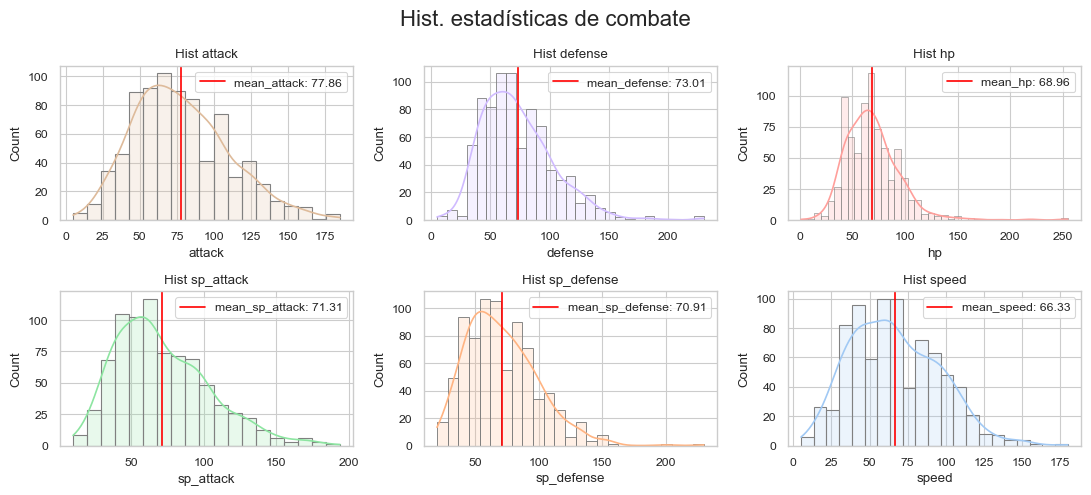

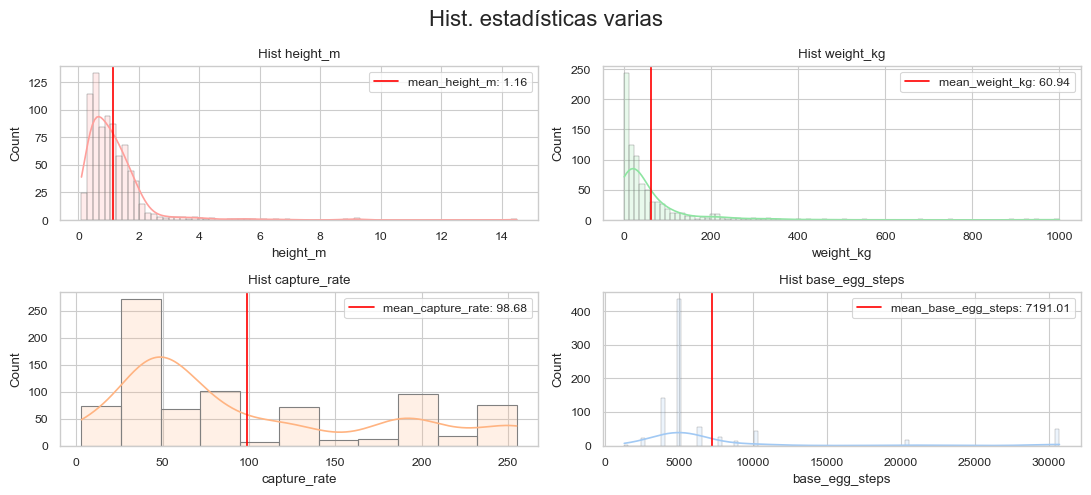

In [168]:
combat_stats = ['attack','defense','hp','sp_attack', 'sp_defense','speed']
other_stats = ['height_m', 'weight_kg','capture_rate','base_egg_steps']

def plot_stats(datos,listado,titulo):
    n_rows=2
    n_cols=math.ceil(len(listado)/2)

    fig,ax = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(11,5))
    count=0
    palette = list(reversed(sns.color_palette("pastel", len(listado)).as_hex()))

    class salida(Exception): pass

    try: 
        for i in range(n_rows):
            for j in range(n_cols):
                # print(i,j)
                sns.histplot(datos[listado[count]], kde=True,color=palette[count],alpha=0.2,edgecolor="gray",ax=ax[i,j])
                # ax[i,j].hist(datos[listado[count]],color=palette[count])
                ax[i,j].axvline([datos[listado[count]].mean()],color="red",label=f"mean_{listado[count]}: {round(datos[listado[count]].mean(),2)}")
                ax[i,j].legend()
                ax[i,j].title.set_text(f'Hist {listado[count]}')

                count+=1
                if count==len(listado): raise salida

    except salida:
        None




    fig.suptitle(titulo, fontsize=16)
    fig.tight_layout()


plot_stats(datos,combat_stats,"Hist. estadísticas de combate")
plot_stats(datos,other_stats,"Hist. estadísticas varias")

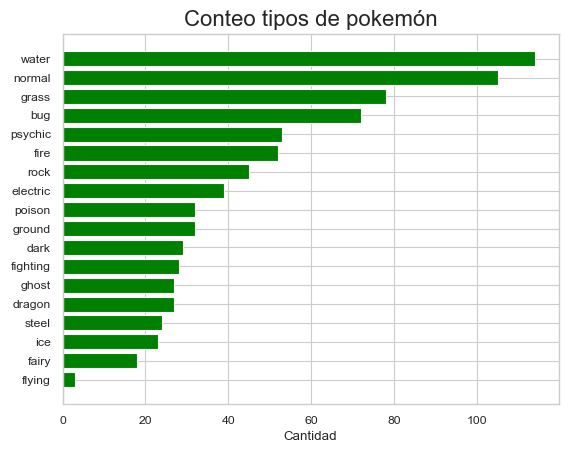

In [169]:
type1_counts = datos["type1"].value_counts().sort_values()
fig, ax = plt.subplots()
ax.barh(type1_counts.index, type1_counts.values, color='green')
ax.set_title("Conteo tipos de pokemón",fontsize=16)
ax.set_xlabel("Cantidad")
plt.show()


# DANIEL 
* Boxplot variables por tipo y legendario

In [170]:
var_corr_1=['against_dark', 'attack', 'base_egg_steps', 'base_total', 'base_total', 'base_total']
var_corr_2=['against_ghost','base_total','is_legendary','capture_rate','sp_attack','sp_defense']
for i in range(len(var_corr_2)):
    fig= px.box(datos,y=var_corr_2[i], x="type1", color="is_legendary")
    fig.update_traces(quartilemethod="exclusive")
    fig.show()

In [171]:

fig= px.box(datos,y="base_egg_steps", x="type1", color="is_legendary")
fig.update_traces(quartilemethod="exclusive")
fig.show()

In [172]:
var_corr_1=['against_dark', 'attack', 'base_egg_steps', 'base_total', 'base_total', 'base_total']
var_corr_2=['against_ghost','base_total','is_legendary','capture_rate','sp_attack','sp_defense']
for i in range(len(var_corr_2)):
    fig= px.scatter(datos,y=var_corr_2[i], x=var_corr_1[i],)
    fig.show()

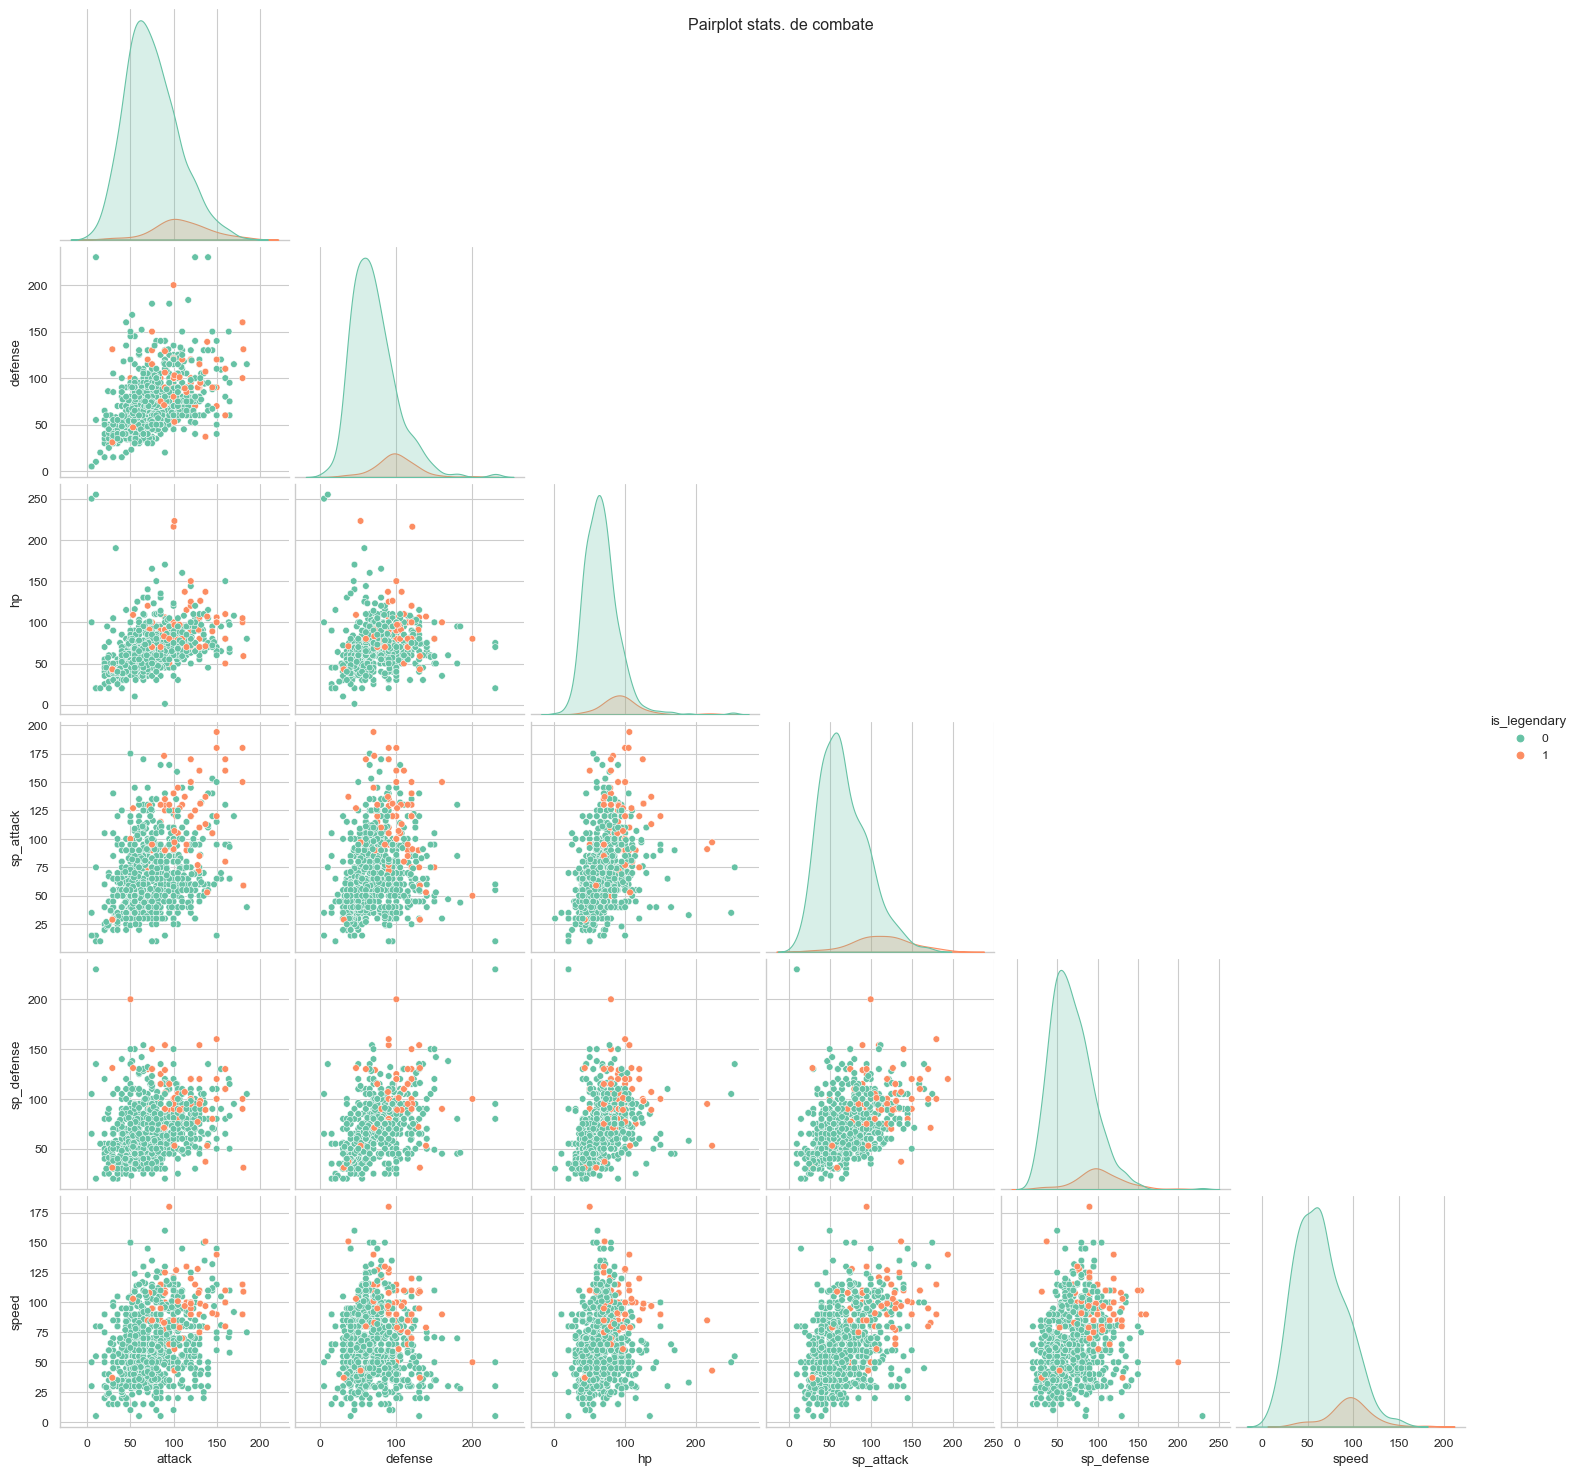

In [173]:

columnas=['attack', 'defense','hp','sp_attack','sp_defense', 'speed','is_legendary']
sns.set_palette("Set2")
sns.pairplot(datos[columnas], hue="is_legendary",corner=True).fig.suptitle('Pairplot stats. de combate')
plt.show()


Se observa que la proporción de los pokemones legendarios es menor que los no legendarios. Estos primeros cuentan con mayor poder de ataque y velocidad. Los pokemones tanto legendarios como no legendarios en su mayoria cuentan con HP menores a 100.

# Filtros


Dados los diferentes alcances del proyecto se realizarán filtros para tener conjuntos de datos apropiados para los análisis posteriores.

No supervisado: 
* agrupar pokemones con características similares

Supervisados:
* clasificador el tipo de pokémon
* clasificador si es legendario


In [174]:
datos_name=datos["name"]
datos = datos.loc[:,~datos.columns.isin(["name"])]

# Análisis de datos
___

## Pruebas de correlación



In [175]:
data_corr = datos.select_dtypes(include=['int','float64'])

def tabla_corr_pearson(data_fixed,alfa,umbral):
  newdf = data_fixed.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
  result = []


  for i in newdf.columns:
    for j in newdf.columns:
      if i!=j:
        coef, p = stats.pearsonr(newdf[i], newdf[j])
        result.append([i,j,coef,p < alfa,p])

  correlaciones = pd.DataFrame(result,columns=["Var_i","Var_j","Coef_corr","Correlacionada","p_value"])


  return correlaciones[(correlaciones.Correlacionada==True) & (abs(correlaciones.Coef_corr)>=umbral)].drop_duplicates(["Coef_corr","p_value"])


tabla_corr_pearson(data_corr,0.05,0.65)

,Var_i,Var_j,Coef_corr,Correlacionada,p_value
41,against_dark,against_ghost,0.672337,True,1.792426e-106
632,attack,base_total,0.730134,True,2.774246e-134
678,base_egg_steps,is_legendary,0.873488,True,5.424174e-252
735,base_total,capture_rate,-0.712275,True,5.908588e-125
741,base_total,sp_attack,0.741120,True,2.107866e-140
742,base_total,sp_defense,0.717434,True,1.416538e-127


## Pipeline para preprocesado de datos

In [176]:
cat_one_hot= ["type1","generation"]
num_scaler = datos.columns[~datos.columns.isin(["type1","generation","is_legendary"])]

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical_data", MinMaxScaler(), num_scaler),
        ("categorical_data", OneHotEncoder(handle_unknown="ignore"), cat_one_hot)
            ]
)
preprocessor

ColumnTransformer(transformers=[('numerical_data', MinMaxScaler(),
                                 Index(['against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass', 'against_ground', 'against_ice',
       'against_normal', 'against_poison', 'against_psychic', 'against_rock',
       'against_steel', 'against_water', 'attack', 'base_egg_steps',
       'base_happiness', 'base_total', 'capture_rate', 'defense',
       'experience_growth', 'height_m', 'hp', 'percentage_male', 'sp_attack',
       'sp_defense', 'speed', 'weight_kg', 'percentage_female'],
      dtype='object')),
                                ('categorical_data',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['type1', 'generation'])])

Muestra del preprocesamiento

In [177]:
a=preprocessor.fit_transform(datos)
a=pd.DataFrame(a)

a.columns=preprocessor.fit(datos).get_feature_names_out()
a.head()

,numerical_data__against_bug,numerical_data__against_dark,numerical_data__against_dragon,numerical_data__against_electric,numerical_data__against_fairy,numerical_data__against_fight,numerical_data__against_fire,numerical_data__against_flying,numerical_data__against_ghost,numerical_data__against_grass,...,categorical_data__type1_rock,categorical_data__type1_steel,categorical_data__type1_water,categorical_data__generation_1,categorical_data__generation_2,categorical_data__generation_3,categorical_data__generation_4,categorical_data__generation_5,categorical_data__generation_6,categorical_data__generation_7
0,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.066667,0.2,0.5,0.250,0.066667,0.250,0.066667,0.200000,0.25,0.066667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066667,0.2,0.5,0.250,0.066667,0.250,0.066667,0.200000,0.25,0.066667,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
a.describe()

,numerical_data__against_bug,numerical_data__against_dark,numerical_data__against_dragon,numerical_data__against_electric,numerical_data__against_fairy,numerical_data__against_fight,numerical_data__against_fire,numerical_data__against_flying,numerical_data__against_ghost,numerical_data__against_grass,...,categorical_data__type1_rock,categorical_data__type1_steel,categorical_data__type1_water,categorical_data__generation_1,categorical_data__generation_2,categorical_data__generation_3,categorical_data__generation_4,categorical_data__generation_5,categorical_data__generation_6,categorical_data__generation_7
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.199001,0.215231,0.484395,0.268493,0.218394,0.266386,0.236122,0.251436,0.246255,0.209072,...,0.056180,0.029963,0.142322,0.188514,0.124844,0.168539,0.133583,0.194757,0.089888,0.099875
std,0.159266,0.116838,0.176529,0.163740,0.139244,0.179313,0.184494,0.161197,0.139564,0.210372,...,0.230412,0.170591,0.349598,0.391367,0.330748,0.374578,0.340416,0.396261,0.286199,0.300021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.066667,0.200000,0.500000,0.125000,0.200000,0.125000,0.066667,0.200000,0.250000,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.200000,0.200000,0.500000,0.250000,0.200000,0.250000,0.200000,0.200000,0.250000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.200000,0.200000,0.500000,0.250000,0.200000,0.250000,0.466667,0.200000,0.250000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modelos

## Modelo para clasificar si un pokémon es o no legendario
___

### Partición de datos

In [179]:
datos.is_legendary.value_counts()

is_legendary
0    731
1     70
Name: count, dtype: int64

Del 100% de los datos se deja 20% como validación, y dado el desbalance entre clases se procede a estratificar dentro de los splits.

In [180]:
x_train_base,x_val, y_train_base,y_val = train_test_split(
    datos.loc[:, datos.columns != 'is_legendary'],
    datos.loc[:,"is_legendary"],
    test_size=0.20,
    shuffle=True,
    stratify=datos.loc[:,"is_legendary"])

Del 80% de entrenamiento, se deja 70% para solo para entrenamiento y 30% de pruebas

In [32]:
x_train,x_test,  y_train,y_test = train_test_split(x_train_base,
                                                   y_train_base,
                                                   test_size=0.30,
                                                   shuffle=True,
                                                   stratify=y_train_base)

### Selección de mejor modelo

In [188]:
models = [
    ("SVM",SVC(random_state=100),
     {'model__C': [0.1, 1, 10, 100, 1000],
      'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'model__kernel': ['rbf',"linear","poly","sigmoid"]}),

    ("Random Forest",RandomForestClassifier(random_state=100),
     {"model__n_estimators":[10,100,200],
      "model__criterion": ["gini", "entropy", "log_loss"],
      "model__max_depth":[None,10,100]}),

    ("Gradient Boosting Descent",GradientBoostingClassifier(random_state=100),
     {"model__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
      "model__min_samples_split": np.linspace(0.1, 0.5, 12),
      "model__min_samples_leaf": np.linspace(0.1, 0.5, 12),
      "model__max_depth":[3,5,10]}),

    ("Naive Bayes",GaussianNB(),
     {'model__var_smoothing': np.logspace(0,-9, num=100)}),

    ("KNN",KNeighborsClassifier(),
     {"model__n_neighbors": list(range(1,15))}),

    ("Redes neuronales",MLPClassifier(random_state=100),
     {'model__solver': ['adam',"sgd"],
     'model__hidden_layer_sizes': [(50,50), (100,100), (100,100,100)],
     'model__activation': ['logistic', 'tanh', 'relu'],
     'model__alpha': [0.0001, 0.001, 0.005],
     'model__early_stopping': [True, False]}),

    ("XGboost",XGBClassifier(objective= 'binary:logistic',random_state=100),
     {'model__max_depth': range (2, 10, 2),
      'model__n_estimators': range(60, 200, 40),
      'model__learning_rate': [0.1, 0.01, 0.05]})
]


modelos = pd.DataFrame(models,columns=["model_name","model","param_grid"])


for i in range(modelos.shape[0]):
    print(modelos["model_name"][i])
    pipe_base = Pipeline([
        ("preprocesamiento",preprocessor),
        ("model",modelos["model"][i])
    ])

    grid_search = GridSearchCV(pipe_base,
                               modelos["param_grid"][i],
                               scoring='balanced_accuracy',
                               cv=5,
                               verbose=0,
                               refit=True,
                               n_jobs=-1) 
    
    grid_search.fit(x_train, y_train)
  
    modelos.loc[i, 'grid_search'] = grid_search
    modelos.loc[i, 'best_score'] = grid_search.best_score_
    modelos.loc[i, 'best_score_on_test'] = grid_search.score(x_test,y_test)


SVM
Random Forest
Gradient Boosting Descent
Naive Bayes
KNN
Redes neuronales
XGboost


In [189]:
modelos.sort_values(by=['best_score'], ascending=False)


,model_name,model,param_grid,grid_search,best_score,best_score_on_test
1,Random Forest,RandomForestClassifier(random_state=100),"{'model__n_estimators': [10, 100, 200], 'model...","GridSearchCV(cv=5,\n estimator=Pip...",0.985046,0.970588
6,XGboost,"XGBClassifier(base_score=None, booster=None, c...","{'model__max_depth': (2, 4, 6, 8), 'model__n_e...","GridSearchCV(cv=5,\n estimator=Pip...",0.971341,1.000000
2,Gradient Boosting Descent,GradientBoostingClassifier(random_state=100),"{'model__learning_rate': [0.01, 0.025, 0.05, 0...","GridSearchCV(cv=5,\n estimator=Pip...",0.957026,0.970588
0,SVM,SVC(random_state=100),"{'model__C': [0.1, 1, 10, 100, 1000], 'model__...","GridSearchCV(cv=5,\n estimator=Pip...",0.948765,0.908908
5,Redes neuronales,MLPClassifier(random_state=100),"{'model__solver': ['adam', 'sgd'], 'model__hid...","GridSearchCV(cv=5,\n estimator=Pip...",0.921326,0.908908
3,Naive Bayes,GaussianNB(),"{'model__var_smoothing': [1.0, 0.8111308307896...","GridSearchCV(cv=5,\n estimator=Pip...",0.913065,0.953445
4,KNN,KNeighborsClassifier(),"{'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8...","GridSearchCV(cv=5,\n estimator=Pip...",0.724811,0.705882


Ahora visualizamos la matriz de confusión de los mejores modelos (mayores 0.94)

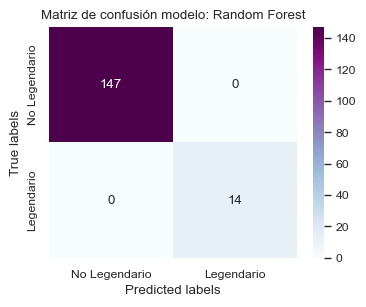

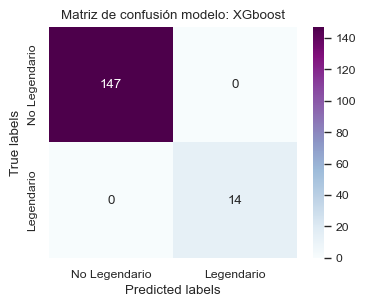

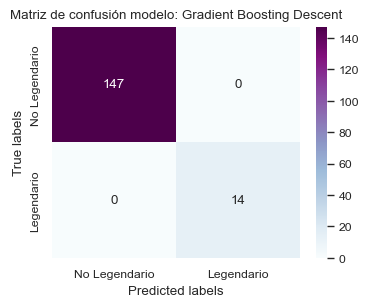

In [190]:
min_score=0.95

def matriz_confusion(modelos,indices):

    for selected in indices:

        cm = confusion_matrix(y_val,
                            modelos["grid_search"][selected].best_estimator_.predict(x_val))

        fig,ax= plt.subplots(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap="BuPu"); 

        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title(f'Matriz de confusión modelo: {modelos["model_name"][selected]}'); 
        ax.xaxis.set_ticklabels(['No Legendario', 'Legendario']); ax.yaxis.set_ticklabels(['No Legendario', 'Legendario']);

matriz_confusion(modelos,list(modelos[modelos.best_score>=min_score].sort_values(by=['best_score'], ascending=False).index))

### PCA

Con esta función se puede ver el cambio de la varianza explicada por los N componentes, teniendo dentro de sus parámetros el porcentaje de varianza explicada deseada.

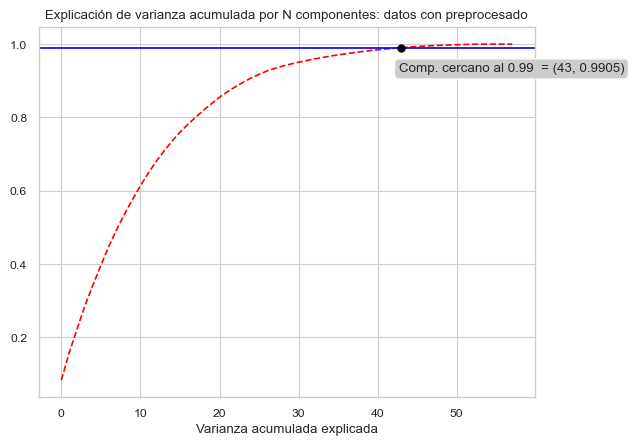

In [191]:
preprocessor.fit_transform(datos)

def graf_pca(datos,limite=0.95,add_title=""):
    """
    datos: data a probar por pca
    limite: cuánta varianza quiere ser explicada
    add_title: parte para añadir al titulo
    ___
    retorna el número de componentes con la varianza explicada más cercana
    """
    pca = PCA() 
    transf = pca.fit_transform(datos)
    
    varianza_expl = pca.explained_variance_ratio_

    var_cum=np.column_stack((range(0,len(varianza_expl)),varianza_expl.cumsum()))

    # limite=0.95
    punto=np.argmin(np.abs(np.array(var_cum[:,1])-limite))


    plt.plot(var_cum[:,0],var_cum[:,1] , '--r')
    plt.axhline(y=limite, color='b')
    plt.title("Explicación de varianza acumulada por N componentes" + add_title)
    plt.xlabel("N componentes")
    plt.xlabel("Varianza acumulada explicada")
    plt.annotate('Comp. cercano al %.2f  = (%.0f, %.4f)'%(limite,punto, var_cum[punto,1]),
                (punto, var_cum[punto,1]-0.07), 
                xytext =(-2 * 1, 1),
                textcoords ='offset points',
                bbox = dict(boxstyle ="round", fc ="0.8"))
    plt.plot(punto, var_cum[punto,1], marker="o", markersize=5, markeredgecolor="black", markerfacecolor="black")
    plt.show;

    return punto

n_comp = graf_pca(preprocessor.fit_transform(datos),0.99,": datos con preprocesado")


Probamos nuevamente los modelos con el número de componentes seleccionados

In [192]:
modelos_pca = modelos[modelos.best_score>=min_score]
modelos_pca=modelos_pca.reset_index()
for i in range(modelos_pca.shape[0]):
    print(modelos_pca["model_name"][i])
    pipe_base = Pipeline([
        ("preprocesamiento",preprocessor),
        ("PCA",PCA(n_components=n_comp, random_state=100)),
        ("model",modelos_pca["model"][i])
    ])

    grid_search = GridSearchCV(pipe_base,
                               modelos_pca["param_grid"][i],
                               scoring='balanced_accuracy',
                               cv=5,
                               verbose=0,
                               refit=True,
                               n_jobs=-1) 
    
    grid_search.fit(x_train, y_train)

    modelos_pca.loc[i, 'grid_search_with_pca'] = grid_search
    modelos_pca.loc[i, 'best_score_with_pca'] = grid_search.best_score_ 
    modelos_pca.loc[i, 'best_score_with_pca_on_test'] = grid_search.score(x_test,y_test)


Random Forest
Gradient Boosting Descent
XGboost


In [218]:
modelos_pca.sort_values(by=['best_score'], ascending=False)

,index,model_name,model,param_grid,grid_search,best_score,best_score_on_test,grid_search_with_pca,best_score_with_pca,best_score_with_pca_on_test
0,1,Random Forest,RandomForestClassifier(random_state=100),"{'model__n_estimators': [10, 100, 200], 'model...","GridSearchCV(cv=5,\n estimator=Pip...",0.985046,0.970588,"GridSearchCV(cv=5,\n estimator=Pip...",0.859495,0.794118
2,6,XGboost,"XGBClassifier(base_score=None, booster=None, c...","{'model__max_depth': (2, 4, 6, 8), 'model__n_e...","GridSearchCV(cv=5,\n estimator=Pip...",0.971341,1.000000,"GridSearchCV(cv=5,\n estimator=Pip...",0.878367,0.882353
1,2,Gradient Boosting Descent,GradientBoostingClassifier(random_state=100),"{'model__learning_rate': [0.01, 0.025, 0.05, 0...","GridSearchCV(cv=5,\n estimator=Pip...",0.957026,0.970588,"GridSearchCV(cv=5,\n estimator=Pip...",0.941448,0.823529


Dado que no se obtuvo mejora al usar PCA el modelo elegido será el Random Forest, dado que presenta mejor balance accuracy en train (best_score) y buen score en datos de test (best_score_on_test).

In [204]:
modelo_m1_final=modelos_pca["grid_search"][0].best_estimator_

### Métricas

In [223]:
print("Datos de prueba")

x,y = x_test,y_test

print(classification_report(y,
                            modelo_m1_final.predict(x),
                            digits=4))

print("\n")
print("Datos de validación")

x,y = x_val,y_val
print(classification_report(y,
                            modelo_m1_final.predict(x),
                            digits=4))


Datos de prueba
              precision    recall  f1-score   support

           0     0.9943    1.0000    0.9972       175
           1     1.0000    0.9412    0.9697        17

    accuracy                         0.9948       192
   macro avg     0.9972    0.9706    0.9834       192
weighted avg     0.9948    0.9948    0.9947       192



Datos de validación
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       147
           1     1.0000    1.0000    1.0000        14

    accuracy                         1.0000       161
   macro avg     1.0000    1.0000    1.0000       161
weighted avg     1.0000    1.0000    1.0000       161



In [ ]:

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(modelo_m1_final[1], out_file='tree.dot', 
                feature_names = list(a.columns),
                class_names = ["0","1"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [261]:
import os
from sklearn.tree import export_graphviz
import six
import pydot
from sklearn import tree
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in modelo_m1_final[1].estimators_:
    export_graphviz(tree_in_forest,out_file='tree.dot',
    feature_names=list(a.columns),
    class_names = ["No Legendario","Legendario"],
    filled=True,
    rounded=True)
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    name = 'tree' + str(i_tree)
    graph.write_png(".\\Modelo_1_trees\\"+name+  '.png')
    os.system('dot -Tpng tree.dot -o tree.png')
    i_tree +=1

## Modelo de agrupación pokémon

### Partición de datos

### Selección de mejor modelo

### PCA

In [39]:
from sklearn.preprocessing import LabelEncoder
tranformacion = LabelEncoder()
data_arreglados=tranformacion.fit_transform(datos.type1)
datos["datos_arreglados"]= data_arreglados
datos[["type1", "datos_arreglados"]].head()

,type1,datos_arreglados
0,grass,9
1,grass,9
2,grass,9
3,fire,6
4,fire,6


In [40]:
### preprocesamiento
type_one_hot= ["generation"]
type_num_scaler = d.columns[~datos.columns.isin(["type1","datos_arreglados","generation","is_legendary"])]

preprocessor_m2 = ColumnTransformer(
    transformers=[
        ("numerical_data", MinMaxScaler(), type_num_scaler),
        ("categorical_data", OneHotEncoder(handle_unknown="ignore"), type_one_hot),    
            ]
)
preprocessor

ColumnTransformer(transformers=[('numerical_data', MinMaxScaler(),
                                 Index(['against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass', 'against_ground', 'against_ice',
       'against_normal', 'against_poison', 'against_psychic', 'against_rock',
       'against_steel', 'against_water', 'attack', 'base_egg_steps',
       'base_happiness', 'base_total', 'capture_rate', 'defense',
       'experience_growth', 'height_m', 'hp', 'percentage_male', 'sp_attack',
       'sp_defense', 'speed', 'weight_kg', 'percentage_female'],
      dtype='object')),
                                ('categorical_data',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['type1', 'generation'])])

In [41]:
a=preprocessor_m2.fit_transform(datos)
a=pd.DataFrame(a)

a.columns=preprocessor_m2.fit(datos).get_feature_names_out()
a.head()

,numerical_data__against_bug,numerical_data__against_dark,numerical_data__against_dragon,numerical_data__against_electric,numerical_data__against_fairy,numerical_data__against_fight,numerical_data__against_fire,numerical_data__against_flying,numerical_data__against_ghost,numerical_data__against_grass,...,numerical_data__speed,numerical_data__weight_kg,numerical_data__percentage_female,categorical_data__generation_1,categorical_data__generation_2,categorical_data__generation_3,categorical_data__generation_4,categorical_data__generation_5,categorical_data__generation_6,categorical_data__generation_7
0,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.228571,0.006801,0.119,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.314286,0.012903,0.119,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.200000,0.2,0.5,0.125,0.066667,0.125,0.466667,0.466667,0.25,0.000000,...,0.428571,0.099920,0.119,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.066667,0.2,0.5,0.250,0.066667,0.250,0.066667,0.200000,0.25,0.066667,...,0.342857,0.008402,0.119,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.066667,0.2,0.5,0.250,0.066667,0.250,0.066667,0.200000,0.25,0.066667,...,0.428571,0.018904,0.119,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:

tipo_eliminar= "flying"
df_clasificacion_multiple= datos.drop(datos[datos["type1"]== tipo_eliminar].index)
datos_type1=datos[["type1","datos_arreglados"]]
df_clasificacion_multiple= df_clasificacion_multiple.drop("type1", axis= 1)
df_clasificacion_multiple.datos_arreglados.value_counts().sort_index()

datos_arreglados
0      72
1      29
2      27
3      39
4      18
5      28
6      52
7       3
8      27
9      78
10     32
11     23
12    105
13     32
14     53
15     45
16     24
17    114
Name: count, dtype: int64

### Partición de datos

In [43]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## se dividen los datos en conjuntos de entrenamiento y prueba

x_train_inicial,x_val_inicial, y_train_inicial,y_val_inicial = train_test_split(
    df_clasificacion_multiple.loc[:, df_clasificacion_multiple.columns != 'datos_arreglados'],
    df_clasificacion_multiple.loc[:,"datos_arreglados"],
    test_size=0.20,
    shuffle=True,
    stratify=datos.loc[:,"datos_arreglados"])

se realiza otra divicion pra los conjuntos de entrenamiento y prueba 

In [44]:
x_train_m2,x_test_m2, y_train_m2,y_test_m2 = train_test_split(x_train_inicial,
                                                   y_train_inicial,
                                                   test_size=0.30,
                                                   shuffle=True,
                                                   stratify=y_train_inicial)

### Selección de mejor modelo

In [139]:


parametros= {'model__C': [ 1, 10, 100, 1000],
      'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'model__kernel': ['rbf',"linear","poly","sigmoid"],
      "model__degree":[3,5,7]}


pipe_base_m2 = Pipeline([
    ("preprocesamiento",preprocessor_m2),
    ("model",SVC())
])


grid_search_m2= GridSearchCV(pipe_base_m2, parametros, scoring='balanced_accuracy',cv=3)
grid_search_m2.fit(x_train_m2,y_train_m2)

d:\Program Files\Python\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('numerical_data',
                                                                         MinMaxScaler(),
                                                                         Index(['against_bug', 'against_dark', 'against_dragon', 'against_electric',
       'against_fairy', 'against_fight', 'against_fire', 'against_flying',
       'against_ghost', 'against_grass', 'against_ground', 'against_ice',
       'against_normal', 'agai...
       'sp_defense', 'speed', 'weight_kg', 'percentage_female'],
      dtype='object')),
                                                                        ('categorical_data',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['generation'])])),
                                       ('model', SVC())]),
             param_grid={'model__C': [1, 10, 100, 1000],
                         'model__degree': [3, 5, 7],
                         'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             scoring='balanced_accuracy')

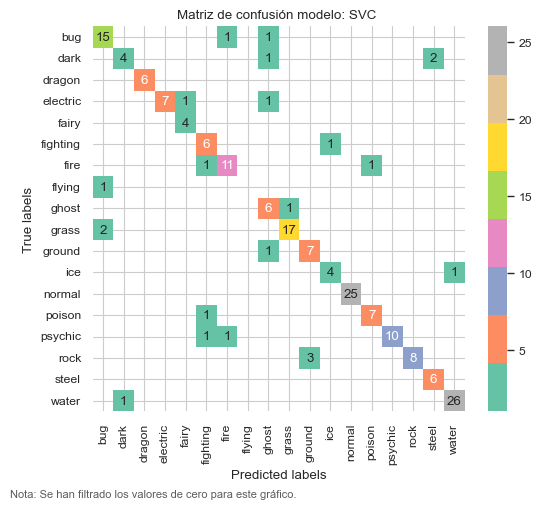

In [140]:
etiquetas=datos_type1.drop_duplicates().sort_values("datos_arreglados")

accuracy_score(y_test_m2, grid_search_m2.best_estimator_.predict(x_test_m2))


cm = confusion_matrix(y_test_m2, grid_search_m2.best_estimator_.predict(x_test_m2))

fig,ax= plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap="Set2",mask=np.invert(cm>0)); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title(f'Matriz de confusión modelo: { "SVC" }'); 
ax.text(-4,22, s='Nota: Se han filtrado los valores de cero para este gráfico.', fontsize=8, alpha=0.75)
ax.xaxis.set_ticklabels(etiquetas.iloc[:,0].to_list(), rotation = 90); 
ax.yaxis.set_ticklabels(etiquetas.iloc[:,0].to_list(), rotation = 0); 


In [137]:
models_m2 = [
    ("SVM",SVC(),
     {'model__C': [0.1, 1, 10, 100, 1000],
      'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'model__kernel': ['rbf',"linear","poly","sigmoid"]}),

    ("Random Forest",RandomForestClassifier(),
     {"model__n_estimators":[10,100,200],
      "model__criterion": ["gini", "entropy", "log_loss"],
      "model__max_depth":[None,10,100]}),

    # ("Gradient Boosting Descent",GradientBoostingClassifier(),
    #  {"model__learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #   "model__min_samples_split": np.linspace(0.1, 0.5, 12),
    #   "model__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    #   "model__max_depth":[3,5,10]}),

    ("Naive Bayes",GaussianNB(),
     {'model__var_smoothing': np.logspace(0,-9, num=100)}),

    ("KNN",KNeighborsClassifier(),
     {"model__n_neighbors": list(range(1,15))}),

    ("Redes neuronales",MLPClassifier(),
     {'model__solver': ['adam',"sgd"],
     'model__hidden_layer_sizes': [(50,50), (100,100), (100,100,100)],
     'model__activation': ['logistic', 'tanh', 'relu'],
     'model__alpha': [0.0001, 0.001, 0.005],
     'model__early_stopping': [True, False]}),

    ("XGboost",XGBClassifier(objective= 'binary:logistic'),
     {'model__max_depth': range (2, 10, 2),
      'model__n_estimators': range(60, 200, 40),
      'model__learning_rate': [0.1, 0.01, 0.05]})
]


modelos_m2 = pd.DataFrame(models_m2,columns=["model_name","model","param_grid"])


for i in range(modelos_m2.shape[0]):

    print(modelos_m2.model_name[i])
    pipe_base_m2 = Pipeline([
        ("preprocesamiento",preprocessor_m2),
        ("model",modelos_m2["model"][i])
    ])


    grid_search_m2= GridSearchCV(pipe_base_m2,
                             modelos_m2["param_grid"][i],
                             scoring='accuracy',
                             cv=1,
                             refit=True,
                             n_jobs=-1)
    

    grid_search_m2.fit(x_train_m2,y_train_m2)
    


    modelos_m2.loc[i, 'grid_search'] = grid_search
    modelos_m2.loc[i, 'best_score'] = grid_search.best_score_

SVM


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

K-means para agrupar los pokémones de acuerdo a sus habilidades 'attack', 'defense', 'hp', 'sp_attack','sp_defense','speed'

In [135]:
modelos_m2

,model_name,model,param_grid,grid_search,best_score
0,SVM,SVC(),"{'model__C': [0.1, 1, 10, 100, 1000], 'model__...","GridSearchCV(cv=3,\n estimator=Pip...",0.883964
1,Random Forest,RandomForestClassifier(),"{'model__n_estimators': [10, 100, 200], 'model...","GridSearchCV(cv=3,\n estimator=Pip...",0.883964
2,Naive Bayes,GaussianNB(),"{'model__var_smoothing': [1.0, 0.8111308307896...","GridSearchCV(cv=3,\n estimator=Pip...",0.883964
3,KNN,KNeighborsClassifier(),"{'model__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8...","GridSearchCV(cv=3,\n estimator=Pip...",0.883964
4,Redes neuronales,MLPClassifier(),"{'model__solver': ['adam', 'sgd'], 'model__hid...","GridSearchCV(cv=3,\n estimator=Pip...",0.883964
5,XGboost,"XGBClassifier(base_score=None, booster=None, c...","{'model__max_depth': (2, 4, 6, 8), 'model__n_e...","GridSearchCV(cv=3,\n estimator=Pip...",0.883964


### PCA

## Modelo K-means para agrupar los pokémones de acuerdo a características similares


In [263]:
datos.set_index('type1', inplace=True)
datos.index

Index(['grass', 'grass', 'grass', 'fire', 'fire', 'fire', 'water', 'water',
       'water', 'bug',
       ...
       'normal', 'rock', 'rock', 'rock', 'poison', 'poison', 'grass', 'ground',
       'psychic', 'rock'],
      dtype='object', name='type1', length=801)

In [276]:
# columnas = ['attack', 'defense', 'hp', 'sp_attack','sp_defense','speed',"is_legendary"]
columnas = datos.columns[~datos.columns.isin(datos.select_dtypes("object"))]
datos_cluster = datos[columnas]
scaler = StandardScaler()
datos_cluster_n = scaler.fit_transform(datos_cluster)


In [277]:
# Gráfica de la varianza explicada acumulada.

def cumulative_explained_variance_plot(expl_variance):

  cum_var_exp = np.cumsum(expl_variance)

  plt.figure(dpi = 105, figsize = (6, 3))
  plt.title('Curva acumulativa de la varianza explicada VS número de componentes principales')
  plt.xlabel('Número de componentes principales')
  plt.ylabel('Varianza explicada acumulativa')  

  nc = np.arange(1, expl_variance.shape[0] + 1)

  plt.plot(nc, cum_var_exp, '--r')
  plt.plot(nc, cum_var_exp, 'c*', ms = 5)   
  plt.show()

Graficando la varianza explicada acumulada buscamos el número de componentes principales que puedan explicar mas del 70% de los datos

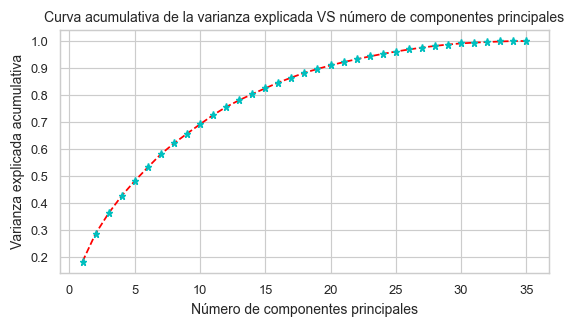

In [278]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None) # Se calculan y almacenan todos los componentes.

pca.fit_transform(datos_cluster_n)
varianza_expl = pca.explained_variance_ratio_

cumulative_explained_variance_plot(varianza_expl)

Seleccionamos 15 componentes principales

In [279]:
pca = PCA(n_components=15)
datos_cluster_pca = pca.fit_transform(datos_cluster_n)
datos_cluster_pca[:5]

array([[-1.9719766 , -1.48535458,  0.78900453,  0.2241475 , -1.10912024,
         1.77863677, -0.70668633, -2.06877995, -0.48640741, -0.3043568 ,
         0.07144477, -1.76608069, -0.14966708,  0.9344116 , -0.15788039],
       [-0.9384473 , -1.64219605,  0.69157609,  0.57593875, -1.51497486,
         1.45773126, -1.07362656, -2.02121184, -0.45562232, -0.53601872,
         0.02540149, -1.57425517, -0.26356301,  0.85396996, -0.16185974],
       [ 1.91928304, -1.83855597,  0.42977566,  1.20826146, -2.79693255,
         0.83160662, -2.0316904 , -1.85440316,  0.19287538, -0.92990104,
         0.12246499, -1.41120842, -0.55704162,  1.00907758,  0.24925281],
       [-1.65627059,  1.6112485 ,  0.48009359,  1.89103417,  0.60112869,
         0.81070106,  0.08413802, -0.80512499, -1.91755843, -0.3704879 ,
         0.61934047, -1.65814362,  1.02014591,  0.61202388,  0.70915026],
       [-0.46282523,  1.4296251 ,  0.36118503,  2.28265265,  0.16480886,
         0.46270434, -0.3284679 , -0.72607009, 

Para seleccionar el número de clusters usamos la inercia o distancia intracluster

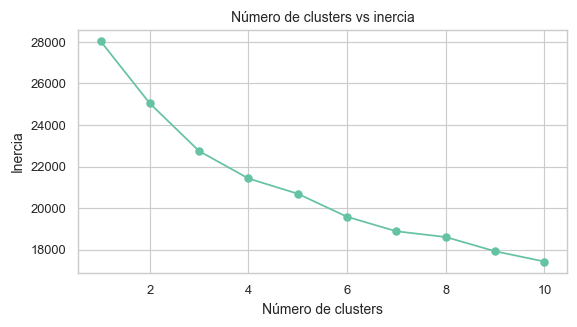

In [280]:
from sklearn.cluster import KMeans
inercias = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=2)
    kmeans.fit(datos_cluster_n)
    inercias.append(kmeans.inertia_)
plt.figure(dpi = 105, figsize = (6, 3))    
plt.plot(range(1, 11), inercias, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Número de clusters vs inercia')
plt.show()

Seleccionamos un cluster de 6

In [320]:
from sklearn.cluster import KMeans
n_clusters = 7
y = KMeans(n_clusters = n_clusters,n_init=2).fit_predict(datos_cluster_pca)

Graficamos los datos según los clusters, donde se resalta el tipo y nombre del pokémon

In [321]:


def plot_pokemon_agrup(X, y, text,tipo,legendario):
  # Nuevo DataFrame con las dos componentes principales y el cluster obtenido. 
  
  datos_cluster_pca = pd.DataFrame(
      {'x': X[:,0],
      'y': X[:,1],
      'cluster': pd.Series(y + 1, dtype = 'string'),
      'name': text,
      "tipo": tipo,
      "legendario":legendario}
  )  
  # datos_cluster_pca = datos_cluster_pca.sort_values(by = 'cluster')
  # Usamos Plotly para graficar los clusters.

  fig = px.scatter(datos_cluster_pca, x="x", y="y", color = 'cluster',
                   size= np.full(len(datos_cluster_pca), 70),
                    text=text,
                   hover_name=text, hover_data=["tipo","legendario"]
                   )
  
  fig.update_traces(textposition="middle center")
  fig.update_layout(
      height = 700,
      title_text = 'Agrupamiento de tipo de pokémon por habilidades',
      uniformtext_minsize=100005,
      uniformtext_mode='hide', 
      dragmode = 'pan',
      font = dict(size = 16)
  )
  fig.update_layout( uniformtext_minsize=80, uniformtext_mode='hide')


  fig.show(config = dict({'scrollZoom': True}))

plot_pokemon_agrup(datos_cluster_pca,y,datos_name.to_list(),list(datos_type1["type1"]) ,list(datos["is_legendary"])  )


Hacemos la evaluación de desempeño a través de la Inercia y el coeficiente de silueta

In [322]:
k = 7
kmeans = KMeans(n_clusters=k)
kmeans.fit(datos_cluster_pca)
inercia = kmeans.inertia_
print("Coeficiente de Inercia:", inercia)

Coeficiente de Inercia: 14196.561098641034


d:\Program Files\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [323]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2,10):
  kmeans = KMeans(n_clusters=k,n_init=2)
  kmeans.fit(datos_cluster_pca)
  y = kmeans.predict(datos_cluster_pca)
  silhouette_scores.append(silhouette_score(datos_cluster_pca, y))
silhouette = silhouette_scores
# print("Coeficiente de silueta", silhouette_scores)

In [324]:
def plot_metric(K, scores, metric_name):
  plt.figure(dpi=110, figsize=(9, 5))
  plt.plot(K, scores, 'bx-')
  plt.xticks(K); plt.xlabel('$k$', fontdict=dict(family = 'serif', size = 14));  plt.ylabel(metric_name, fontdict=dict(family = 'serif', size = 14));
  plt.title(f'K vs {metric_name}', fontdict=dict(family = 'serif', size = 18))
  plt.show()

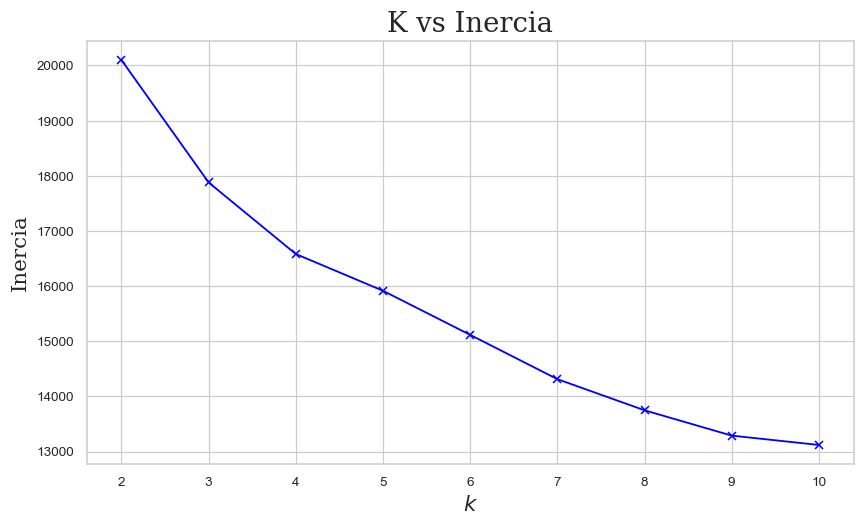

In [325]:
inertia = []
silhouette = []
K = range(2, 11)
for i in K:
  # Declaramos y ejecutamos el algoritmo K-means.
  model = KMeans(n_clusters=i, n_init=2)
  model.fit(datos_cluster_pca)

  # Predecimos las etiquetas de X_preprocessed.
  y = model.predict(datos_cluster_pca)

  # Almacenamos la métrica de inercia y el coeficiente de silueta.
  inertia.append(model.inertia_)
  silhouette.append(silhouette_score(datos_cluster_pca, y))
  

plot_metric(K, inertia, 'Inercia')

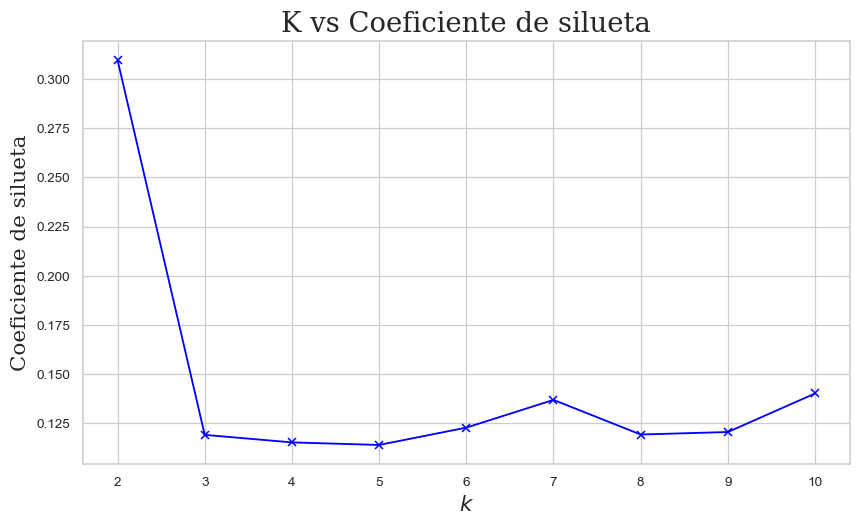

In [319]:
plot_metric(K, silhouette, 'Coeficiente de silueta')

In [ ]:
from sklearn.preprocessing import LabelEncoder

normalizacion = LabelEncoder()
a=normalizacion.fit_transform(datos.type1)
datos["datos_arreglado"]=a


In [ ]:
c=datos.loc[:,["type1","datos_arreglado"]]
pd.unique(c.values.ravel("k"))

array(['grass', 'fire', 'water', 'bug', 'normal', 'poison', 'electric',
       'fairy', 'fighting', 'psychic', 'ghost', 'rock', 'ground', 'ice',
       'dragon', 'dark', 'steel', 'flying', 9, 6, 17, 0, 12, 13, 3, 4, 5,
       14, 8, 15, 10, 11, 2, 1, 16, 7], dtype=object)

## Seleccion de muestras para entrenamiento, prueba y validacion

Separacion de datos de entrenamiento  y validadcion
una vez separado los datos de validacion se ptocede a utilizar los datos destinados para el entrenamiento en 70% para entrenamiento y 20 para prueba

separacion de datos para entrenamiento y prueba

In [ ]:

x_train_SVM,x_test_SVM,  y_train_SVM,y_test_SVM = train_test_split(x_train_inicial,
                                                   y_train_inicial,
                                                   test_size=0.30,
                                                   shuffle=True,
                                                   stratify=y_train_inicial)

## Seleccion de hiperparametros

In [547]:
from sklearn.model_selection import ParameterGrid


parameters = {'C': [0.1, 1, 10], 'kernel': ['rbf',"linear","polynomial","sigmoid"], 'gamma': [0.1, 1, 10]}
##genero combinaciones de parametros
param_grid = ParameterGrid(parameters)
##creo el modelo para seleccion de hiperparametros
model = svm.SVC()
grid_search= GridSearchCV(model, param_grid)

### entrenar el modelo de hiperparametros GridsearchCV
grid_search.fit(_train, y_train)


pipe_inicial = Pipeline([
    ("preprocesamiento",preprocessor)
    ])

grid_search_SVM = GridSearchCV(pipe_inicial,
                               param_grid= model_SVM,
                               scoring='accuracy',
                               cv=3,
                               verbose=0,
                               refit=True,
                               n_jobs=-1)
grid_search_SVM.fit(x_train_SVM, y_train_SVM)
grid_search_SVM.best_params_
grid_search_SVM.score(x_train_SVM, y_train_SVM)

NameError: name '_train' is not defined

Métricas:

- Clasificación

  - Accuracy
  - Precision (Macro, Micro, Average)
  - Recall (Macro, Micro, Average)
  - F1-Score (Macro, Micro, Average)
  - Sensitivity
  - Auc-PR
  - Auc-ROC
  - Matriz de confusión

- Regresión:

  - MSE (mean squared error)
  - RMSE (root mean squared erro)
  - Log MSE
  - MAE( mean average error)
  - R^2

Metodología para encontrar hiperparametros con grid search cv o random search cv

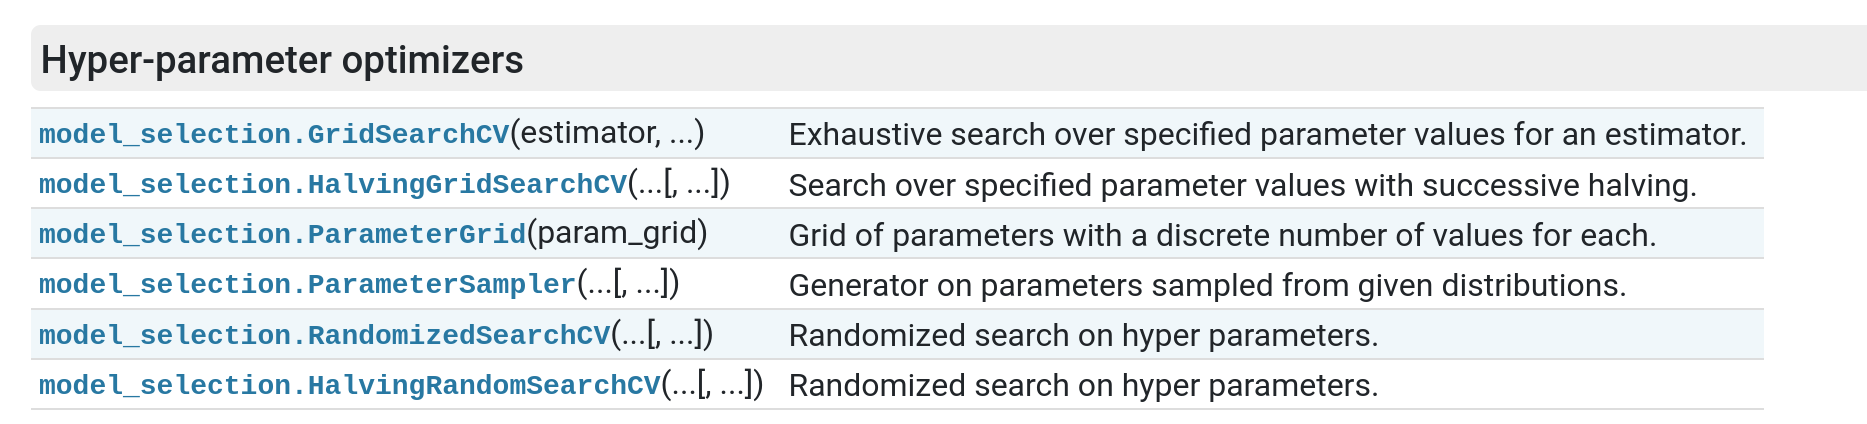

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

## ¿Cuál fue el mejor algoritmo que funcionó para sus datos?

## ¿Por qué cree que fue el que mejor funcionó?
## ¿Qué otras técnicas cree que puede utilizar para mejorar su algoritmo?

## ¿Los métodos aplicados le ayudaron a responder sus preguntas con base en los datos? Trate de mostrar gráficamente la información extraida del proceso.
## ¿Le hicieron falta datos?, realice una conjetura sobre como podría obtener mejores resultados.